In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time

# import tensorflow.contrib.eager as tfe

# tf.enable_eager_execution()

In [ ]:
PATH='data/digit-recognizer/'
SZ=28
BATCH_SIZE=128
STEPS = 1000
MODEL_DIR='models/mnist_64rs_2dense'

In [4]:
data = pd.read_csv(f'{PATH}train.csv')
display(data.head())
features, labels = data, data.pop('label')
labels.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

(28, 28)


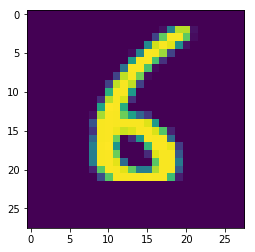

In [5]:
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
f = np.asarray(features, dtype=np.float32).reshape(-1, 28,28)
# resized_features = []
# for i, img in enumerate(f):
#     image = resize(img, (224, 224), preserve_range=True)
#     resized_features.append(image)
#     if i % 1000 == 0:
#         print(i)

# np.shape(resized_features)
image = f[45]
plt.imshow(image)
# image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
# image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
plt.imshow(image)
print(image.shape)

In [6]:
"""
Numpy input for same type data
Pandas input for structure data
"""

features = np.asarray(features, dtype=np.float32)
labels = np.asarray(labels, dtype=np.int64)

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(features, labels, test_size=0.2)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_x},
    y = train_y,
    batch_size = BATCH_SIZE,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": val_x},
    y=val_y,
    num_epochs=1,
    shuffle=False)

In [7]:
# """
# Save train and val as csv file
# """

# from sklearn.model_selection import train_test_split
# data = pd.read_csv(f'{PATH}train.csv')
# train_data, val_data = train_test_split(data, test_size=0.2)
# print(np.shape(train_data))

# np.savetxt(f"{PATH}train/train.csv", train_data, delimiter=",")
# np.savetxt(f"{PATH}val/val.csv", val_data, delimiter=",")


In [10]:
def cnn_model(features, labels, mode, params):
    """
    MODEL
    """
    ## 64 image resized
    x = tf.reshape(features["x"], [-1, SZ, SZ, 1]) # Channel first NCWH
    x = tf.image.resize_images(x, [64, 64], method=3)
    
    x = tf.layers.conv2d(x, 32, kernel_size=[5, 5], 
                             padding="same", activation=tf.nn.relu)
    x = tf.layers.max_pooling2d(x, pool_size=[2, 2], strides=2)


    x = tf.layers.conv2d(x, 64, kernel_size=[5, 5], 
                             padding="same", activation=tf.nn.relu)
    x = tf.layers.max_pooling2d(x, pool_size=[2, 2], strides=2)


    x = tf.layers.conv2d(x, 256, kernel_size=[5, 5], 
                             padding="same", activation=tf.nn.relu)
    x = tf.layers.max_pooling2d(x, pool_size=[2, 2], strides=2)

    x_flat = tf.reshape(x, [-1, 8 * 8 * 256])
    
    ## 2 dense
#     input_layer = tf.reshape(features["x"], [-1, SZ, SZ, 1]) # Channel first NCWH
#     conv1 = tf.layers.conv2d(input_layer, 32, kernel_size=[5, 5], 
#                              padding="same", activation=tf.nn.relu)
#     pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2], strides=2)
#     conv2 = tf.layers.conv2d(pool1, 64, kernel_size=[5, 5], 
#                              padding="same", activation=tf.nn.relu)
#     pool2 = tf.layers.max_pooling2d(conv2, pool_size=[2, 2], strides=2)

#     x_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])


    dense = tf.layers.dense(inputs=x_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    dense = tf.layers.dense(inputs=dropout, units=512, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=10)
    
    """ 
    PREDICT 
    """
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)


    """ 
    EVAL 
    """
    # Add evaluation metrics (for EVAL mode)
    
    accuracy = tf.metrics.accuracy(labels=labels,
                                    predictions=predictions["classes"],
                                    name='acc_op')
    metrics={'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    """ 
    TRAIN 
    """
    # Configure the Training Op (for TRAIN mode)
    assert mode == tf.estimator.ModeKeys.TRAIN
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    

In [15]:
# Maximum CPU usage 4 cores
session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=4,
      inter_op_parallelism_threads=4)

classifier = tf.estimator.Estimator(
    cnn_model, 
    model_dir=MODEL_DIR,
    config=tf.estimator.RunConfig(session_config=session_conf),
    params=[]
)

INFO:tensorflow:Using config: {'_model_dir': 'models/mnist_64rs_2dense', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': intra_op_parallelism_threads: 4
inter_op_parallelism_threads: 4
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0d7eea4d30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
## Numpy input
for _ in range(5):
    classifier.train(
        input_fn=train_input_fn,
        steps=STEPS
    )
    
    # Evaluate the model and print results
    eval_results = classifier.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into models/mnist_64rs_2dense/model.ckpt.
INFO:tensorflow:loss = 18.504086, step = 0
INFO:tensorflow:global_step/sec: 6.33064
INFO:tensorflow:loss = 0.55224466, step = 100 (15.796 sec)
INFO:tensorflow:global_step/sec: 6.47047
INFO:tensorflow:loss = 0.3421954, step = 200 (15.455 sec)
INFO:tensorflow:global_step/sec: 6.42134
INFO:tensorflow:loss = 0.31255823, step = 300 (15.575 sec)
INFO:tensorflow:global_step/sec: 6.50138
INFO:tensorflow:loss = 0.27999875, step = 400 (15.380 sec)
INFO:tensorflow:global_step/sec: 6.46871
INFO:tensorflow:loss = 0.22711183, step = 500 (15.458 sec)
INFO:tensorflow:global_step/sec: 6.54322
INFO:tensorflow:loss = 0.20637622, step = 600 (15.284 sec)
INFO:tensorflow:global_step/sec: 6.396

In [47]:
test = pd.read_csv(f'{PATH}test.csv')
test_x = np.asarray(test, dtype=np.float32)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_x},
    y=None,
    num_epochs=1,
    shuffle=False)

In [48]:
predictions = classifier.predict(input_fn=predict_input_fn)

In [49]:
results=[['ImageId', 'Label']]
for i, prediction in enumerate(predictions):
    results.append([i+1, prediction['classes']])
    

INFO:tensorflow:Calling model_fn.
trainning 0.05855703353881836
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/mnist_2dense/model.ckpt-63037
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [50]:
len(results)

28001

In [51]:
np.savetxt("csv/mnist.csv", np.asarray(results), delimiter=",", fmt="%s")

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16755167410071435482
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9836206490
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13532950072095365337
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
